We are introducing different normalization techniques in the code that gave 99.4% acccuracy.
1. Layer Normaization
2. Group Normalization
3. Batch Normalization along with L1 regularization

# Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [5]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab_Notebooks/EVA8/normalizationTechniques')
from model import Net
import config as cf

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [7]:
## CONSTANTS
SEED=42
DROPOUT_VALUE = 0.1
NUM_GROUPS_FOR_GN = 2
LAMBDA=5e-4
EPOCHS=20

## Data Transformations



In [8]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.RandomRotation((-8.0, 8.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [9]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [10]:
#SEED = 42

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model
Let's start with the model we first saw

In [12]:

# import torch.nn.functional as F
# #dropout_value = DROPOUT_VALUE
# #num_groups = NUM_GROUPS_FOR_GN

# class Net(nn.Module):
#     def __init__(self,use_norm):
#         super(Net, self).__init__()
#         self.use_norm=use_norm
#         # Input Block
        
#         if self.use_norm=='BATCH':
#           norm1=nn.BatchNorm2d(14) ## adding self.norm1 adds the paramtere two times
#         elif self.use_norm=='LAYER':
#           norm1=nn.LayerNorm([14,26,26])
#         else:# self.use_norm=='GROUP':
#           norm1=nn.GroupNorm (NUM_GROUPS_FOR_GN,14)

#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             norm1,
#             nn.Dropout(DROPOUT_VALUE)
#         ) # output_size = 26

        
#         # CONVOLUTION BLOCK 1
        
#         if self.use_norm=='BATCH':
#           norm2=nn.BatchNorm2d(28)
#         elif self.use_norm=='LAYER':
#           norm2=nn.LayerNorm([28,24,24])
#         elif self.use_norm=='GROUP':
#           norm2=nn.GroupNorm (NUM_GROUPS_FOR_GN,28)


#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=14, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             norm2,
#             nn.Dropout(DROPOUT_VALUE)
#         ) # output_size = 24

#         # TRANSITION BLOCK 1
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=28, out_channels=12, kernel_size=(1, 1), padding=0, bias=False),
#         ) # output_size = 24
#         self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

#         # CONVOLUTION BLOCK 2
#         if self.use_norm=='BATCH':
#           norm3=nn.BatchNorm2d(14)
#           norm4=nn.BatchNorm2d(12)
#           norm5=nn.BatchNorm2d(12)
#           norm6=nn.BatchNorm2d(12)
        
#         elif self.use_norm=='LAYER':
#           norm3=nn.LayerNorm([14,10,10])
#           norm4=nn.LayerNorm([12,8,8])
#           norm5=nn.LayerNorm([12,6,6])
#           norm6=nn.LayerNorm([12,6,6])
          
#         elif self.use_norm=='GROUP':
#           norm3=nn.GroupNorm (NUM_GROUPS_FOR_GN,14)
#           norm4=nn.GroupNorm (NUM_GROUPS_FOR_GN,12)
#           norm5=nn.GroupNorm (NUM_GROUPS_FOR_GN,12)
#           norm6=nn.GroupNorm (NUM_GROUPS_FOR_GN,12)
        
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),            
#             norm3,
#             nn.Dropout(DROPOUT_VALUE)
#         ) # output_size = 10
#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=14, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),            
#             norm4,
#             nn.Dropout(DROPOUT_VALUE)
#         ) # output_size = 8
#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),            
#             norm5,
#             nn.Dropout(DROPOUT_VALUE)
#         ) # output_size = 6

#         self.convblock7 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),            
#             norm6,
#             nn.Dropout(DROPOUT_VALUE)
#         ) # output_size = 6
        
#         # OUTPUT BLOCK
#         self.gap = nn.Sequential(
#             nn.AvgPool2d(kernel_size=6)
#         ) # output_size = 1

#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#         )

#         self.dropout = nn.Dropout(DROPOUT_VALUE)

#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.convblock3(x)
#         x = self.pool1(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)
#         x = self.convblock7(x)
#         x = self.gap(x)        
#         x = self.convblock8(x)
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)


#       

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [13]:
model = Net("GROUP").to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
         GroupNorm-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 28, 24, 24]           3,528
              ReLU-6           [-1, 28, 24, 24]               0
         GroupNorm-7           [-1, 28, 24, 24]              56
           Dropout-8           [-1, 28, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             336
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,512
             ReLU-12           [-1, 14, 10, 10]               0
        GroupNorm-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1, 14,

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [14]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer,use_L1_regularization,epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    nll_loss = F.nll_loss(y_pred, target)
    
    
    ## only in case of Batch Normalization
    if use_L1_regularization==True:
      #print("using the L1 regularization")
      reg_loss = sum([torch.sum(abs(param)) for param in model.parameters()])
      loss= nll_loss + LAMBDA * reg_loss
    else:
      loss = nll_loss


    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [15]:
from torch.optim.lr_scheduler import StepLR
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=15)
lstNorms=['LAYER','BATCH','GROUP']
modelNamePrefix="normalizationModels_"
train_losses_dict = {}
test_losses_dict = {}
train_acc_dict = {}
test_acc_dict = {}
use_L1_regularization=False

for norm in lstNorms:
  print("******** using the "+ norm+" noramlization technique ************")
  model =  Net(norm).to(device)
  ## oprimizerr & Scheduler
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  #scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  
  ## variables to hold the losses & accuracy
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)
      #print('LR:', scheduler.get_last_lr())
      if(norm=="BATCH"):
        use_L1_regularization=True      
      train(model, device, train_loader, optimizer,use_L1_regularization, epoch)
      test(model, device, test_loader)
      #scheduler.step()
  torch.save(model,"/content/drive/MyDrive/Colab_Notebooks/EVA8/normalizationTechniques/Models/"+modelNamePrefix+"_"+norm)
  del model
  
  t=[t.cpu().item() for t in train_losses]
  train_losses_dict[norm]=t
  test_losses_dict[norm]=test_losses
  train_acc_dict[norm]=train_acc
  test_acc_dict[norm]=test_acc



******** using the LAYER noramlization technique ************
EPOCH: 0


Loss=0.1402161419391632 Batch_id=468 Accuracy=82.13: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]



Test set: Average loss: 0.1838, Accuracy: 9586/10000 (95.86%)

EPOCH: 1


Loss=0.08600936084985733 Batch_id=468 Accuracy=96.79: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.0748, Accuracy: 9823/10000 (98.23%)

EPOCH: 2


Loss=0.04755660519003868 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:17<00:00, 26.39it/s]



Test set: Average loss: 0.0612, Accuracy: 9832/10000 (98.32%)

EPOCH: 3


Loss=0.06456423550844193 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:17<00:00, 26.35it/s]



Test set: Average loss: 0.0559, Accuracy: 9835/10000 (98.35%)

EPOCH: 4


Loss=0.03855995461344719 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:17<00:00, 26.59it/s]



Test set: Average loss: 0.0379, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.09049808233976364 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]



Test set: Average loss: 0.0374, Accuracy: 9893/10000 (98.93%)

EPOCH: 6


Loss=0.021616511046886444 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:17<00:00, 26.47it/s]



Test set: Average loss: 0.0293, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.023606477305293083 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 26.41it/s]



Test set: Average loss: 0.0316, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.07828015834093094 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.0295, Accuracy: 9911/10000 (99.11%)

EPOCH: 9


Loss=0.011390302330255508 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:18<00:00, 25.78it/s]



Test set: Average loss: 0.0298, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.010474145412445068 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 26.31it/s]



Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.011690839193761349 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:17<00:00, 26.36it/s]



Test set: Average loss: 0.0272, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.042521730065345764 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:18<00:00, 25.76it/s]



Test set: Average loss: 0.0302, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


Loss=0.009629773907363415 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0272, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.034883737564086914 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:17<00:00, 26.23it/s]



Test set: Average loss: 0.0259, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.03571765124797821 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:18<00:00, 25.88it/s]



Test set: Average loss: 0.0265, Accuracy: 9916/10000 (99.16%)

EPOCH: 16


Loss=0.03400259092450142 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:18<00:00, 25.99it/s]



Test set: Average loss: 0.0298, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.03368214890360832 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]



Test set: Average loss: 0.0250, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.011252143420279026 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:18<00:00, 25.67it/s]



Test set: Average loss: 0.0283, Accuracy: 9916/10000 (99.16%)

EPOCH: 19


Loss=0.017315400764346123 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:17<00:00, 26.26it/s]



Test set: Average loss: 0.0244, Accuracy: 9926/10000 (99.26%)

******** using the BATCH noramlization technique ************
EPOCH: 0


Loss=0.33334875106811523 Batch_id=468 Accuracy=88.04: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]



Test set: Average loss: 0.1250, Accuracy: 9629/10000 (96.29%)

EPOCH: 1


Loss=0.29144468903541565 Batch_id=468 Accuracy=96.92: 100%|██████████| 469/469 [00:19<00:00, 24.49it/s]



Test set: Average loss: 0.0587, Accuracy: 9808/10000 (98.08%)

EPOCH: 2


Loss=0.23092518746852875 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:18<00:00, 25.21it/s]



Test set: Average loss: 0.0489, Accuracy: 9847/10000 (98.47%)

EPOCH: 3


Loss=0.2760586142539978 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:18<00:00, 25.34it/s]



Test set: Average loss: 0.0734, Accuracy: 9757/10000 (97.57%)

EPOCH: 4


Loss=0.2640596032142639 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.0432, Accuracy: 9871/10000 (98.71%)

EPOCH: 5


Loss=0.20461390912532806 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:18<00:00, 25.29it/s]



Test set: Average loss: 0.0487, Accuracy: 9842/10000 (98.42%)

EPOCH: 6


Loss=0.3236957788467407 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:18<00:00, 25.23it/s]



Test set: Average loss: 0.0431, Accuracy: 9858/10000 (98.58%)

EPOCH: 7


Loss=0.20268923044204712 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]



Test set: Average loss: 0.0500, Accuracy: 9830/10000 (98.30%)

EPOCH: 8


Loss=0.3284672498703003 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:18<00:00, 25.26it/s]



Test set: Average loss: 0.0496, Accuracy: 9849/10000 (98.49%)

EPOCH: 9


Loss=0.28353482484817505 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:18<00:00, 25.35it/s]



Test set: Average loss: 0.0435, Accuracy: 9857/10000 (98.57%)

EPOCH: 10


Loss=0.19784533977508545 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:18<00:00, 25.39it/s]



Test set: Average loss: 0.0430, Accuracy: 9875/10000 (98.75%)

EPOCH: 11


Loss=0.1897834688425064 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:18<00:00, 25.49it/s]



Test set: Average loss: 0.0486, Accuracy: 9856/10000 (98.56%)

EPOCH: 12


Loss=0.22028712928295135 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:18<00:00, 25.13it/s]



Test set: Average loss: 0.0443, Accuracy: 9860/10000 (98.60%)

EPOCH: 13


Loss=0.24603287875652313 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]



Test set: Average loss: 0.0383, Accuracy: 9878/10000 (98.78%)

EPOCH: 14


Loss=0.24506111443042755 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]



Test set: Average loss: 0.0413, Accuracy: 9882/10000 (98.82%)

EPOCH: 15


Loss=0.1941656917333603 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:21<00:00, 21.55it/s]



Test set: Average loss: 0.0392, Accuracy: 9878/10000 (98.78%)

EPOCH: 16


Loss=0.2193867564201355 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:20<00:00, 23.06it/s]



Test set: Average loss: 0.0475, Accuracy: 9845/10000 (98.45%)

EPOCH: 17


Loss=0.20506557822227478 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:18<00:00, 25.18it/s]



Test set: Average loss: 0.0497, Accuracy: 9856/10000 (98.56%)

EPOCH: 18


Loss=0.22920776903629303 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:18<00:00, 25.19it/s]



Test set: Average loss: 0.0372, Accuracy: 9890/10000 (98.90%)

EPOCH: 19


Loss=0.18538497388362885 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:19<00:00, 23.87it/s]



Test set: Average loss: 0.0421, Accuracy: 9865/10000 (98.65%)

******** using the GROUP noramlization technique ************
EPOCH: 0


Loss=0.4269391894340515 Batch_id=468 Accuracy=80.35: 100%|██████████| 469/469 [00:19<00:00, 23.73it/s]



Test set: Average loss: 0.1278, Accuracy: 9660/10000 (96.60%)

EPOCH: 1


Loss=0.29619574546813965 Batch_id=468 Accuracy=96.57: 100%|██████████| 469/469 [00:19<00:00, 23.72it/s]



Test set: Average loss: 0.0759, Accuracy: 9784/10000 (97.84%)

EPOCH: 2


Loss=0.2837376594543457 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:19<00:00, 24.50it/s]



Test set: Average loss: 0.0591, Accuracy: 9826/10000 (98.26%)

EPOCH: 3


Loss=0.2286786437034607 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:19<00:00, 24.66it/s]



Test set: Average loss: 0.0508, Accuracy: 9852/10000 (98.52%)

EPOCH: 4


Loss=0.282257080078125 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:19<00:00, 24.29it/s]



Test set: Average loss: 0.0572, Accuracy: 9827/10000 (98.27%)

EPOCH: 5


Loss=0.30794858932495117 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s]



Test set: Average loss: 0.0662, Accuracy: 9814/10000 (98.14%)

EPOCH: 6


Loss=0.33072829246520996 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:19<00:00, 24.41it/s]



Test set: Average loss: 0.0494, Accuracy: 9855/10000 (98.55%)

EPOCH: 7


Loss=0.24396538734436035 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:19<00:00, 23.85it/s]



Test set: Average loss: 0.0481, Accuracy: 9860/10000 (98.60%)

EPOCH: 8


Loss=0.22120115160942078 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]



Test set: Average loss: 0.0437, Accuracy: 9874/10000 (98.74%)

EPOCH: 9


Loss=0.25016897916793823 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:19<00:00, 24.43it/s]



Test set: Average loss: 0.0621, Accuracy: 9818/10000 (98.18%)

EPOCH: 10


Loss=0.21606214344501495 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:19<00:00, 23.84it/s]



Test set: Average loss: 0.0517, Accuracy: 9831/10000 (98.31%)

EPOCH: 11


Loss=0.27314355969429016 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:19<00:00, 24.14it/s]



Test set: Average loss: 0.0409, Accuracy: 9871/10000 (98.71%)

EPOCH: 12


Loss=0.26397964358329773 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:19<00:00, 24.55it/s]



Test set: Average loss: 0.0431, Accuracy: 9886/10000 (98.86%)

EPOCH: 13


Loss=0.21748103201389313 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:19<00:00, 24.45it/s]



Test set: Average loss: 0.0319, Accuracy: 9897/10000 (98.97%)

EPOCH: 14


Loss=0.2543211281299591 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:19<00:00, 24.41it/s]



Test set: Average loss: 0.0448, Accuracy: 9870/10000 (98.70%)

EPOCH: 15


Loss=0.1907690018415451 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:19<00:00, 24.25it/s]



Test set: Average loss: 0.0526, Accuracy: 9846/10000 (98.46%)

EPOCH: 16


Loss=0.17174012959003448 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:19<00:00, 23.61it/s]



Test set: Average loss: 0.0513, Accuracy: 9846/10000 (98.46%)

EPOCH: 17


Loss=0.1925705522298813 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:19<00:00, 24.52it/s]



Test set: Average loss: 0.0411, Accuracy: 9874/10000 (98.74%)

EPOCH: 18


Loss=0.2758805751800537 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:19<00:00, 23.98it/s]



Test set: Average loss: 0.0462, Accuracy: 9867/10000 (98.67%)

EPOCH: 19


Loss=0.20668570697307587 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:19<00:00, 24.07it/s]



Test set: Average loss: 0.0383, Accuracy: 9888/10000 (98.88%)



## Plotting the Results

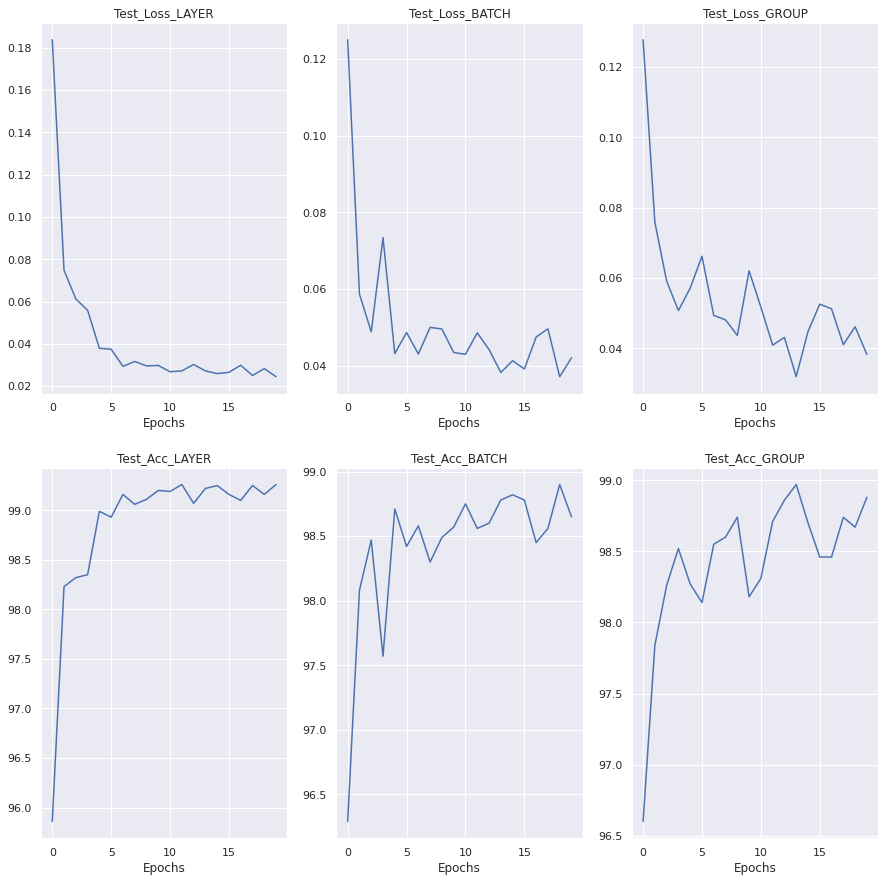

In [16]:

## first bdirn the data to the cpu
import numpy as np
t=[t.cpu().item() for t in train_losses]
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, axs = plt.subplots(2,3,figsize=(15,15))
num_col=3
num_row=2
for i in range(num_row):
  for j in range(num_col):
    if(i==0):
      axs[i, j].plot(test_losses_dict[lstNorms[j]])
      axs[i,j].set_title("Test_Loss_"+lstNorms[j])
      #axs[i,j].set_xticks(range(0,21))

    else:
      axs[i, j].plot(test_acc_dict[lstNorms[j]])
      axs[i,j].set_title("Test_Acc_"+lstNorms[j])
    axs[i,j].set_xlabel("Epochs")  

plt.show()


     

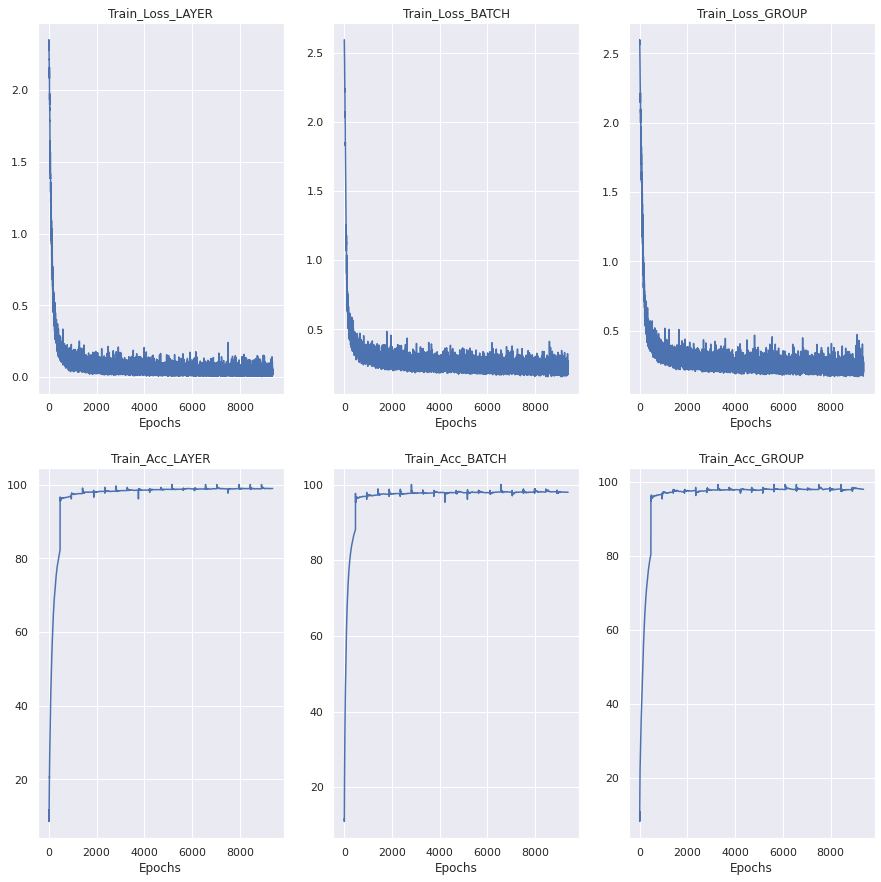

In [21]:
## first bdirn the data to the cpu
import numpy as np
#t=[t.cpu().item() for t in train_losses]
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, axs = plt.subplots(2,3,figsize=(15,15))
num_col=3
num_row=2
for i in range(num_row):
  for j in range(num_col):
    if(i==0):
      axs[i, j].plot(train_losses_dict[lstNorms[j]])
      axs[i,j].set_title("Train_Loss_"+lstNorms[j])
      #axs[i,j].set_xticks(range(0,21))

    else:
      axs[i, j].plot(train_acc_dict[lstNorms[j]])
      axs[i,j].set_title("Train_Acc_"+lstNorms[j])
    axs[i,j].set_xlabel("Epochs")  

plt.show()

## Checking for Misclassifications

In [22]:
def get_misclassified(model, device, test_loader):
    misclassified = []
    misclassified_pred = []
    misclassified_target = []
    # put the model to evaluation mode
    model.eval()
    # turn off gradients
    with torch.no_grad():
        for data, target in test_loader:
            # move them to the respective device
            data, target = data.to(device), target.to(device)
            # do inferencing
            output = model(data)
            # get the predicted output
            pred = output.argmax(dim=1, keepdim=True)

            # get the current misclassified in this batch
            list_misclassified = (pred.eq(target.view_as(pred)) == False)
            batch_misclassified = data[list_misclassified]
            batch_mis_pred = pred[list_misclassified]
            batch_mis_target = target.view_as(pred)[list_misclassified]

            # batch_misclassified =

            misclassified.append(batch_misclassified)
            misclassified_pred.append(batch_mis_pred)
            misclassified_target.append(batch_mis_target)

    # group all the batched together
    misclassified = torch.cat(misclassified)
    misclassified_pred = torch.cat(misclassified_pred)
    misclassified_target = torch.cat(misclassified_target)

    return list(map(lambda x, y, z: (x, y, z), misclassified, misclassified_pred, misclassified_target))
     

In [19]:
def plotMisclassified(misclassified):
  import seaborn as sns
  import matplotlib.pyplot as plt
  num_images = 10
  num_row=5
  num_col=2
  #fig = plt.figure()
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for idx, (image, pred, target) in enumerate(misclassified[:num_images]):
      image, pred, target = image.cpu().numpy(), pred.cpu(), target.cpu()
      # ax = fig.add_subplot(2, 5, idx+1)
      ax=axes[idx//num_col, idx%num_col]
      ax.axis('off')

      ax.set_title('\ntarget {},pred {}'.format(target.item(), pred.item()), fontsize=10)
      ax.imshow(image,interpolation='bilinear')
      ax.axis('off')
  #plt.tight_layout()
  #plt.figure(12,12)
  plt.show()

Getting Misclassifications for the Model with Norm  LAYER


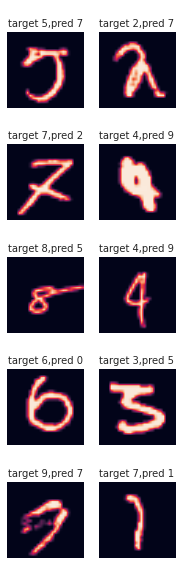

********************************
Getting Misclassifications for the Model with Norm  BATCH


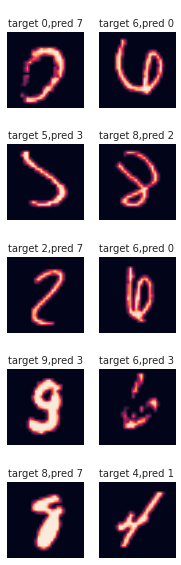

********************************
Getting Misclassifications for the Model with Norm  GROUP


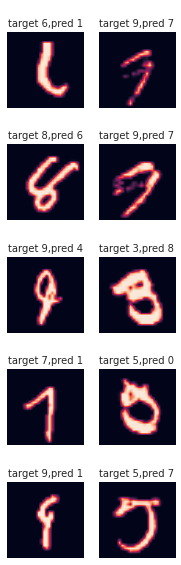

********************************


In [23]:
for norm in lstNorms:
  print("Getting Misclassifications for the Model with Norm ",norm)
  model=torch.load("/content/drive/MyDrive/Colab_Notebooks/EVA8/normalizationTechniques/Models/"+modelNamePrefix+"_"+norm)
  misclassified = get_misclassified(model, device, test_loader)
  plotMisclassified(misclassified)
  print("********************************")
